# 1. Setup

In [1]:
import sys
sys.path.append('../..')
import mobiquity as mq
from mobiquity.names import *

# 2. Prepare data

## 2.1. TIGER/Line zones
Download the zone boundary shapefiles for the continental U.S. (lower 48 + DC) for the relevant spatial scales for **2010** and **2020**. However, due to how the TIGER database handles stuff before 2010, the 2011 data is used instead of 2010.

In [2]:
states = U.load(DATA / 'us_states.csv').disp()

49 rows x 3 cols; Memory: 0.0 MiB


,name,code,fips
,<object>,<object>,<int64>
0,Alabama,AL,1


In [3]:
def download_us_shp(scale, year, states=states, overwrite=False):
    outpath = DATA / f'zones/tiger/{scale}_{year}.parquet'
    if outpath.exists() and not overwrite: return
    df = mq.geo.get_tiger_shp(scale, year, state_code=list(states.fips))
    df.to_parquet(U.mkfile(outpath))

for year, scale in it.product([2010, 2020], [
        'state', 'cbsa', 'county', 'place', 'tract', 'bg']):
    download_us_shp(scale, year, overwrite=0) # total 6m44s

cnty20 = U.load(DATA / 'zones/tiger/county_2020.parquet').disp()

3,234 rows x 5 cols; Memory: 0.5 MiB; <Geographic 2D CRS: EPSG:4326>


,geoid,name,aland,awater,geometry
,<object>,<object>,<int64>,<int64>,<geometry>
0,01001,Autauga,1539634184,25674812,"POLYGON ((-86.903096 32.540626, -86.903115 32...."


## 2.2. Remove waters
The original US counties and states layers include areas with only water and no land. They don't look good for mapping purposes, so instead combine tracts (which don't include waters) to counties and states.

In [4]:
def remove_waters(scale, year, overwrite=False):
    outpath = DATA / f'zones/tiger/{scale}_{year}_nowater.parquet'
    if (df := U.checkfile(outpath, overwrite)) is not None: return df
    df = U.load(DATA / f'zones/tiger/{scale}_{year}.parquet', geom=False,
                columns=['geoid', 'name', 'aland', 'awater'])
    tr = U.load(DATA / f'zones/tiger/tract_{year}.parquet', filters=[
        ('aland', '>', 0)], columns=['geoid', 'geometry'])
    nchar = D(county=5, state=2)[scale]
    tr['geoid'] = tr['geoid'].str[:nchar]
    tr = tr.dissolve('geoid').reset_index()
    df = tr.merge(df, on='geoid')
    df = df[['geoid', 'name', 'aland', 'awater', 'geometry']]
    df.to_parquet(U.mkfile(outpath))

# remove_waters('county', 2020) # 1m28s
# remove_waters('county', 2010) # 1m17s
# remove_waters('state', 2010) # 1m41s
# remove_waters('state', 2020) # 1m52s

## 2.3. Urban areas

In [5]:
# urba = mq.geo.get_urban_areas() # 50s
# urba.to_parquet(DATA / 'zones/tiger/urban_areas_2020.parquet')
urba = U.load(DATA / 'zones/tiger/urban_areas_2020.parquet').disp()

273,434 rows x 3 cols; Memory: 18.9 MiB


,urba,scale,geoid
,<category>,<category>,<object>
0,"Montgomery, AL",Tract,01001020100


### 2.3.1. Largest metro areas
Select the top 50 most populous Metropolitan Statistical Areas (MSAs) for access data preparation. To do this, compute each MSA's population by adding the population of all its constituent BGs, sort them by population and select the top MSAs.

In [6]:
top_msas = (
    U.load(DATA / 'ses/acs/acs_2021.parquet',
           filters=[('scale', '==', 'BG')], columns=['geoid', 'popu'])
    .merge(urba, on='geoid').groupby('urba')['popu'].sum().astype(int)
    .sort_values(ascending=False).reset_index()
    .head(50))
top_msas['msa'] = [x.split(',')[0].split('-')[0].split('/')[0]
                   for x in top_msas['urba']]
top_msas.disp(); pass

50 rows x 3 cols; Memory: 0.2 MiB


,urba,popu,msa
,<category>,<int64>,<object>
0,"New York--Jersey City--Newark, NY--NJ",19448016,New York


## 2.4. Combine attributes

In [7]:
def get_zones(year, urba=urba, top_msas=top_msas,
              states=states, overwrite=False):
    outpath = DATA / f'zones/zones_{year}.parquet'
    if (df := U.checkfile(outpath, overwrite)) is not None: return df
    assert year in [2010, 2020], year
    df = pd.concat([U.load(DATA / f'zones/tiger/{scale}_{year}.parquet')
                    .assign(scale=label) for scale, label in [
                        ('tract', 'Tract'), ('bg', 'BG')]])
    df = df.merge(urba.astype(D(urba=str)), 'left', on=('geoid', 'scale'))
    df['cnty_id'] = df.geoid.str[:5]
    cnty = (U.load(DATA / f'zones/tiger/county_{year}_nowater.parquet')
            .rename(columns=D(name='county', geoid='cnty_id')))
    df = df.merge(cnty[['cnty_id', 'county']], on='cnty_id')
    cnty2urba = (df.groupby(['urba', 'cnty_id'])['aland'].sum()
                 .sort_values(ascending=0).reset_index()
                 [['cnty_id', 'urba']].drop_duplicates(['cnty_id']))
    cnty = cnty.merge(cnty2urba, 'left', on='cnty_id')
    cnty = cnty.rename(columns=D(cnty_id='geoid')).assign(scale='County')
    df = pd.concat([cnty, df])
    df = df.merge(top_msas.astype(D(urba=str)), 'left', on='urba')
    df['fips'] = df.geoid.str[:2].astype(int)
    df = df.merge(states.rename(columns=D(code='state')), on='fips')
    df['aland'] *= U.SQM2SQMI
    df['awater'] *= U.SQM2SQMI
    df = df.astype(D(scale=CAT, state=CAT, county=CAT, urba=CAT,
                     msa=CAT, aland=F32, awater=F32))
    df['top_msa'] = ~df['msa'].isna()
    df = df.to_crs(CRS_M)['geoid scale state county urba top_msa '
                          'msa aland awater geometry'.split()]
    df.to_parquet(U.mkfile(outpath), compression='gzip')
    return df

zones10 = get_zones(2010).disp() # 2m9s
zones20 = get_zones(2020).disp() # 1m4s

291,977 rows x 10 cols; Memory: 26.2 MiB; <Projected CRS: EPSG:3857>


,geoid,scale,state,county,urba,top_msa,msa,aland,awater,geometry
,<object>,<category>,<category>,<category>,<category>,<bool>,<category>,<float32>,<float32>,<geometry>
0,01001,County,AL,Autauga,"Montgomery, AL",False,NaN,594.43335,9.952005,"POLYGON ((-9624353.111696 3816718.739514, -962..."


325,077 rows x 10 cols; Memory: 29.2 MiB; <Projected CRS: EPSG:3857>


,geoid,scale,state,county,urba,top_msa,msa,aland,awater,geometry
,<object>,<category>,<category>,<category>,<category>,<bool>,<category>,<float32>,<float32>,<geometry>
0,01001,County,AL,Autauga,"Montgomery, AL",False,NaN,594.453369,9.913054,"POLYGON ((-9624353.111696 3816718.739514, -962..."


### 2.4.1. Export for Indiana

In [8]:
U.filt(zones10, state='IN').to_parquet(DATA / 'zones/in_2010.parquet')
U.filt(zones20, state='IN').to_parquet(DATA / 'zones/in_2020.parquet')

## 2.5. Export for OSRM

In [ ]:
def get_zone_centroids(level, year=2020, overwrite=False):
    outpath = DATA / f'zones/osrm_export/{level}_{year}.parquet'
    if (df := U.checkfile(outpath, overwrite)) is not None: return df
    path = DATA / f'zones/zones_{year}.parquet'
    cols = ['geoid', 'scale', level, 'geometry']
    if level == 'msa':
        df = U.load(path, columns=cols, filters=[('top_msa', '==', True)])
    else:
        df = U.load(path, columns=cols)
    df = df.rename(columns={level: 'region'})
    df.geometry = df.to_crs(CRS_M).centroid.to_crs(CRS_DEG)
    xy = df.geometry.get_coordinates()
    xy.columns = ['centerx', 'centery']
    df = pd.concat([df[['geoid', 'scale', 'region']], xy], axis=1)
    df.to_parquet(U.mkfile(outpath))
    return df

msaPts = get_zone_centroids('msa', overwrite=0).disp() # 13s
# statePts10 = get_zone_centroids('state', 2010, overwrite=0).disp(0) # 19s
# statePts20 = get_zone_centroids('state', overwrite=0).disp(0) # 20s

144,489 rows x 5 cols; Memory: 12.0 MiB


,geoid,scale,region,centerx,centery
,<object>,<category>,<category>,<float64>,<float64>
0,04013,County,Phoenix,-112.490651,33.351998


## 2.6. Cross-tabulation
[Relationship files](https://www.census.gov/geographies/reference-files/time-series/geo/relationship-files.2020.html) show the mapping between the old (2010) and the new (2020) zones for [block groups](https://www2.census.gov/geo/docs/maps-data/data/rel2020/blkgrp/tab20_blkgrp20_blkgrp10_natl.txt), [tracts](https://www2.census.gov/geo/docs/maps-data/data/rel2020/tract/tab20_tract20_tract10_natl.txt), [counties](https://www2.census.gov/geo/docs/maps-data/data/rel2020/cousub/tab20_cousub20_cousub10_natl.txt).

### 2.6.1. Area overlaps

In [9]:
# xtab = mq.geo.get_census_crosstab_2010_2020().disp() # 3s
# xtab.to_parquet(DATA / 'zones/crosstab_2010_2020.parquet')
xtab = pd.read_parquet(DATA / 'zones/crosstab_2010_2020.parquet').disp()

463,776 rows x 9 cols; Memory: 82.5 MiB


,scale,geoid10,geoid20,aland10,aland20,aland_part,awater10,awater20,awater_part
,<category>,<object>,<object>,<int64>,<int64>,<int64>,<int64>,<int64>,<int64>
0,Tract,01001020100,01001020100,9827271,9825304,9820448,28435,28435,28435


### 2.6.2. Mapping based on centroid

In [10]:
# map10to20 = mq.geo.get_zone_map10to20(zones10, zones20).disp() # 9s
# map10to20.to_parquet(DATA / 'zones/mapping_2010_2020.parquet')
map10to20 = pd.read_parquet(DATA / 'zones/mapping_2010_2020.parquet').disp()

325,077 rows x 3 cols; Memory: 61.1 MiB


,geoid1,geoid2,scale
,<object>,<object>,<object>
0,01001,01001,County


# 3. Visualize

## 3.1. Largest MSAs

In [11]:
msa20 = (U.load(DATA / 'zones/zones_2020.parquet',
                filters=[('top_msa', '==', True), ('scale', '==', 'Tract')])
         [['msa', 'geometry']].dissolve('msa').reset_index()).disp()
xy = msa20.centroid.get_coordinates()
msa20 = pd.concat([msa20, xy], axis=1).disp() # 28s

50 rows x 2 cols; Memory: 0.0 MiB; <Projected CRS: EPSG:3857>


,msa,geometry
,<category>,<geometry>
0,Atlanta,"POLYGON ((-9456011.658897 3929034.468802, -945..."


50 rows x 4 cols; Memory: 0.0 MiB; <Projected CRS: EPSG:3857>


,msa,geometry,x,y
,<category>,<geometry>,<float64>,<float64>
0,Atlanta,"POLYGON ((-9456011.658897 3929034.468802, -945...",-9393565.605711,3997765.313264


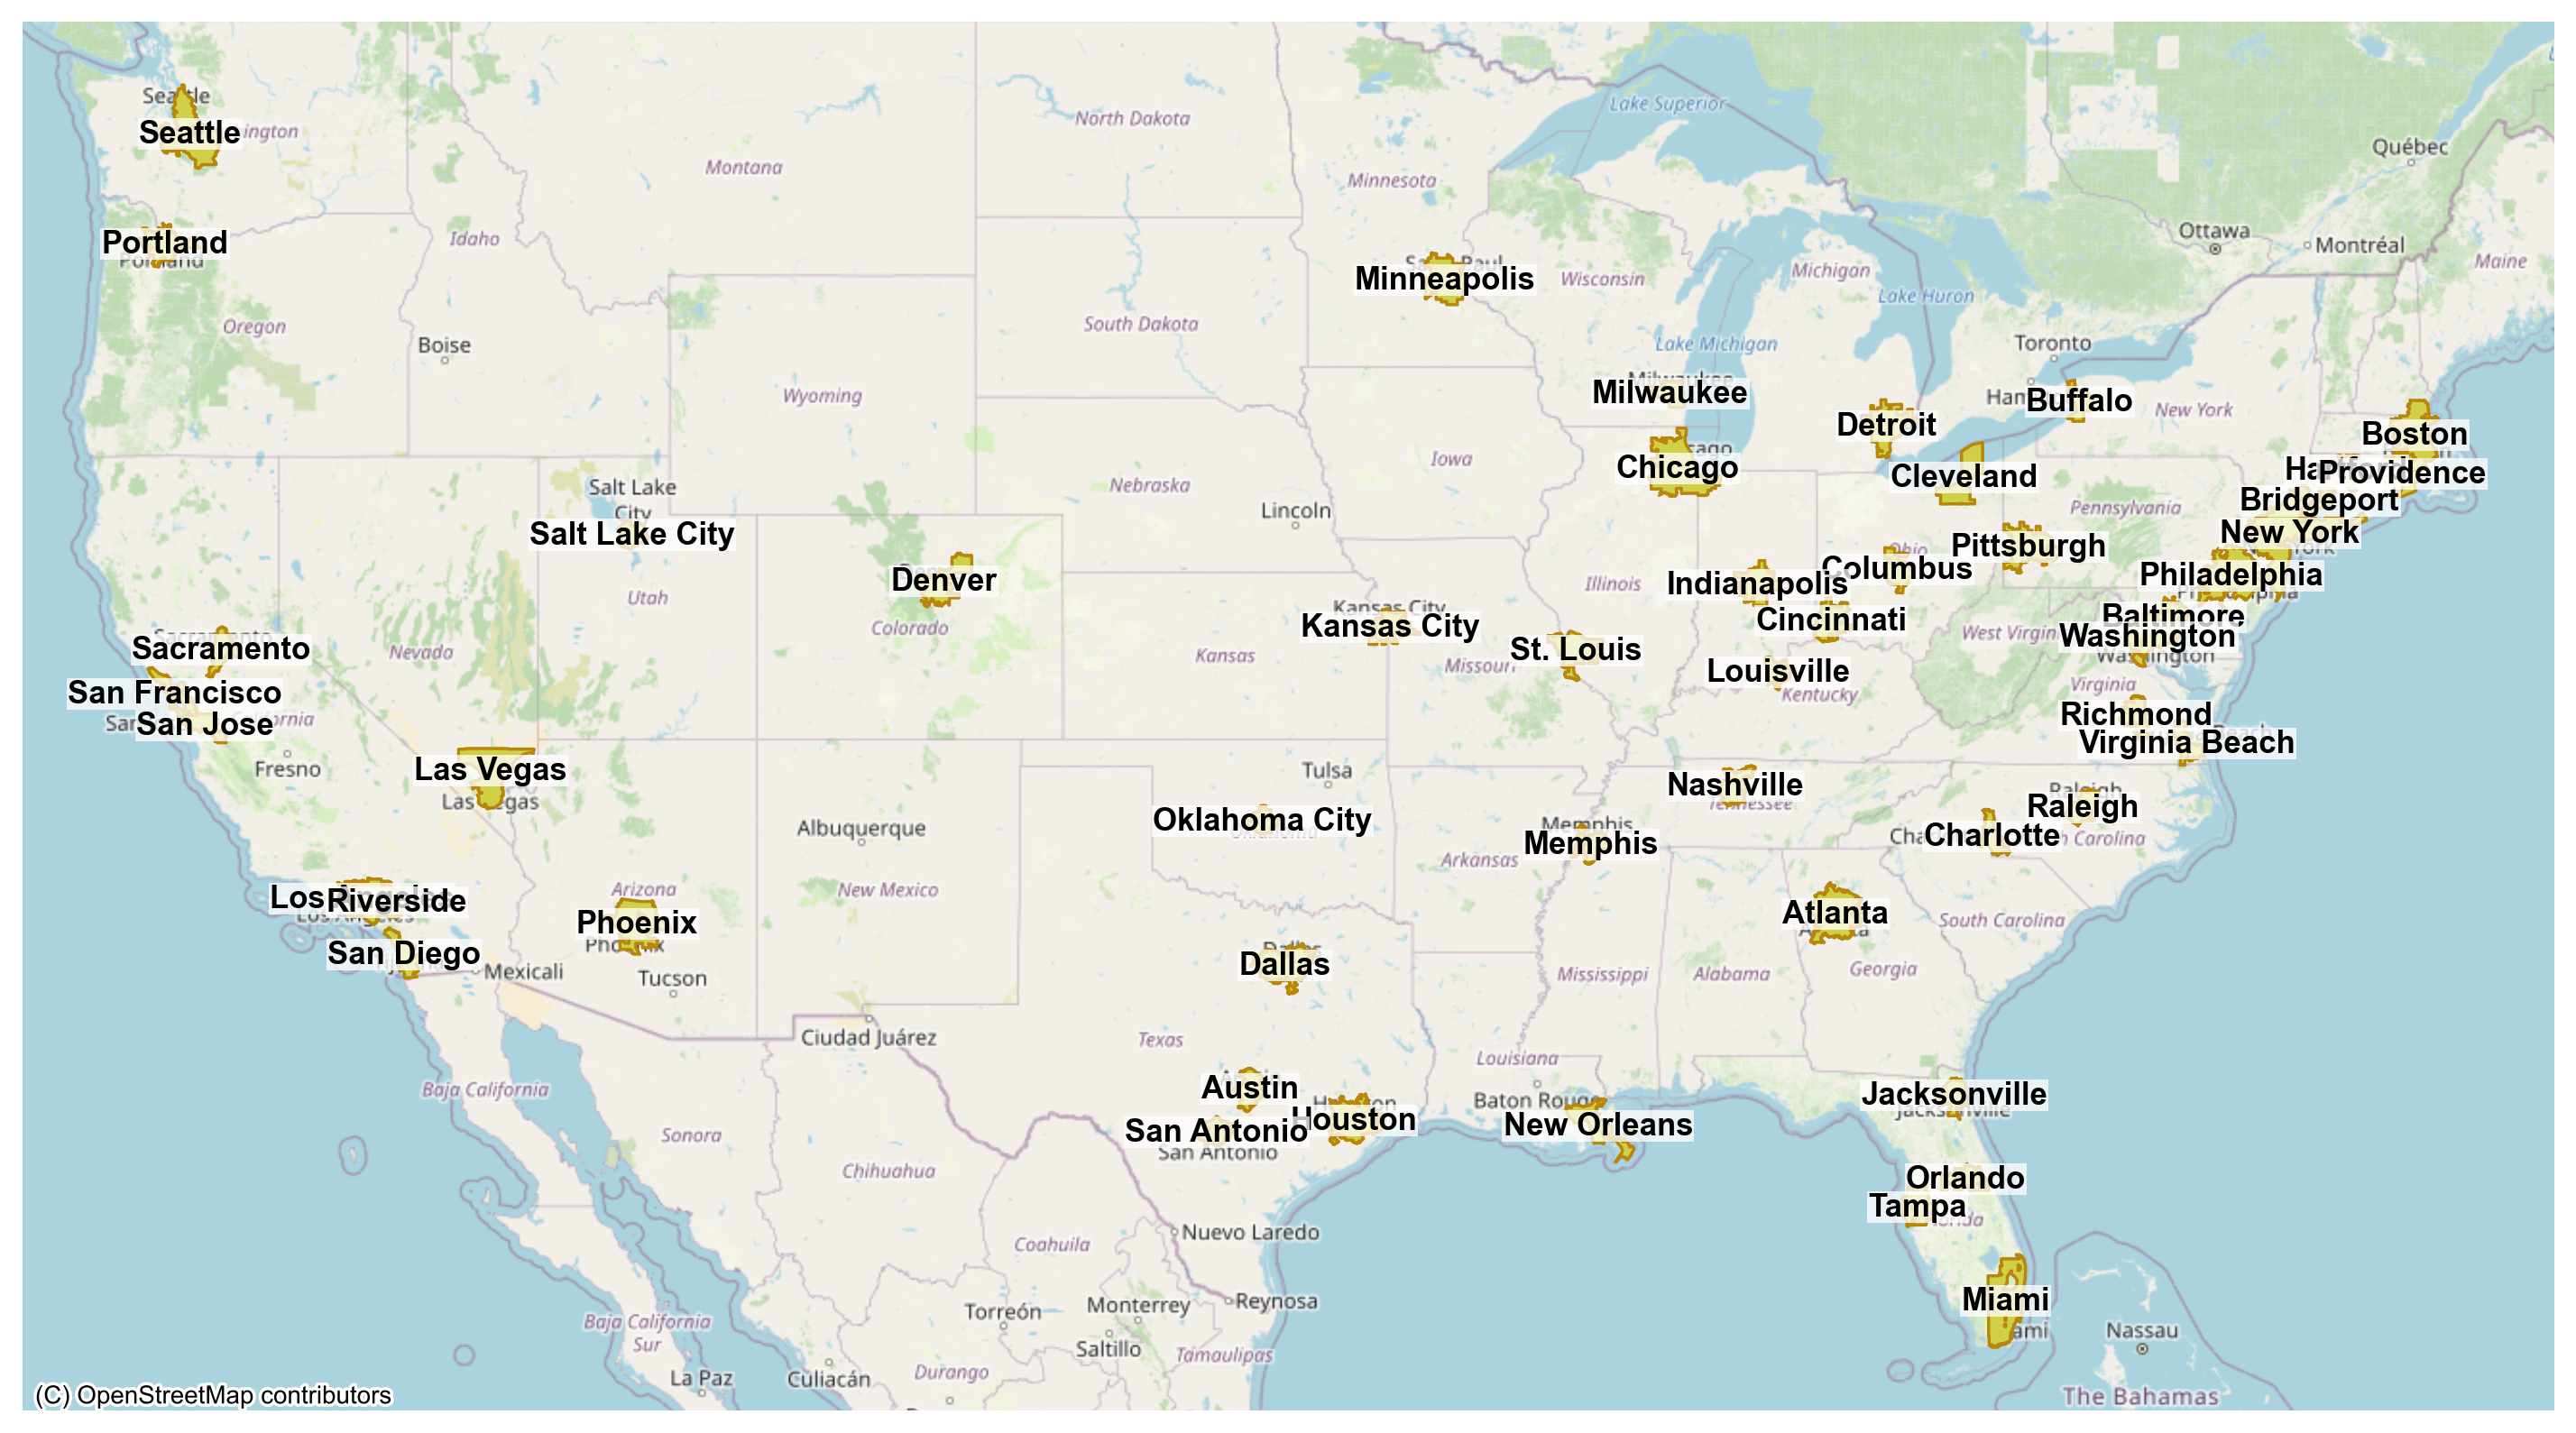

In [12]:
ax = U.plot(size=(20, 8), dpi=250, axoff=1)
msa20.plot(ax=ax, color='#D0D048', ec='#B8860B', lw=1)
for _, r in msa20.iterrows():
    ax.text(r.x, r.y, r.msa, fontweight='bold', 
            ha='center', va='center', fontsize=10,
            bbox=D(fc='w', ec='none', pad=0.3, alpha=0.75))
ctx.add_basemap(source=ctx.providers.OpenStreetMap.Mapnik,
                ax=ax, crs=CRS_M); # 3s